
# 📈 Monthly Sales Forecasting — Prophet, ARIMA, and LSTM (Polished Project)

**Author:** Ajay Kumar  
**Goal:** Forecast **monthly total sales** using the Kaggle **Demand Forecasting** dataset with three models: **Prophet**, **ARIMA (SARIMA)**, and **LSTM**; compare performance with RMSE/MAE/MAPE; and visualize Actual vs Forecast.

> Dataset: [Kaggle - Store Item Demand Forecasting Challenge] (daily sales with columns like `date, store, item, sales`).  
> **We will aggregate to monthly totals** for a clean, business-friendly forecast.



## 1. Environment & Requirements

Run the cell below to install dependencies **if needed** (uncomment the lines).

- Core: `pandas`, `numpy`, `matplotlib`, `scikit-learn`
- Classical TS: `statsmodels` (SARIMA)
- Prophet (a.k.a. `prophet`)
- Deep Learning: `tensorflow` (for LSTM)

> **Note:** Prophet requires a working C++ build toolchain on some systems. If `prophet` install fails, try `pip install prophet` (newer) or `pip install fbprophet` (older), and ensure `pystan` or `cmdstanpy` is installed as required by your environment.


In [1]:

# !pip install pandas numpy matplotlib scikit-learn statsmodels prophet tensorflow
# If prophet install gives issues on Windows:
# !pip install prophet --no-binary=:all:



## 2. Imports


In [2]:

import os
import math
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prophet
try:
    from prophet import Prophet
except Exception as e:
    print("Prophet import failed. Install with `pip install prophet`. Error:", e)

# TensorFlow / Keras
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    from sklearn.preprocessing import MinMaxScaler
except Exception as e:
    print("TensorFlow import failed. Install with `pip install tensorflow`. Error:", e)



## 3. Load Data

Set the path to **Kaggle Demand Forecasting** CSV (e.g., `train.csv`).  
This dataset has **daily** sales for multiple stores & items.  
We will **aggregate to monthly** **total sales across all stores & items** (strict monthly forecasting).

> If you want to forecast per store or per item, set the `GROUP_MODE` accordingly.


In [3]:

# === CONFIG ===
DATA_PATH = 'demand_forecasting_dataset.csv'  # <-- Change if needed, e.g., r'D:/data/demand-forecasting/train.csv'
DATE_COL = 'date'
SALES_COL = 'price'

# GROUP MODE:
# 'total' -> total sales across all store+item (monthly)
# 'store' -> forecast per store (set TARGET_ID below)
# 'item'  -> forecast per item (set TARGET_ID below)
GROUP_MODE = 'total'
TARGET_ID = 1  # used only if GROUP_MODE != 'total'

assert os.path.exists(DATA_PATH), f"Data file not found at {DATA_PATH}. Please update DATA_PATH."

df_raw = pd.read_csv(DATA_PATH, parse_dates=[DATE_COL])
df_raw['date'] = pd.to_datetime(df_raw['date'], format='%d-%m-%Y', errors='coerce')
df_raw.sort_values(DATE_COL, inplace=True)
df_raw.head()


,date,product_id,category_id,store_id,historical_sales,price,promotion_flag,holiday_flag,economic_index,target_demand
0,2022-01-02,1043,4,9,16,48.29,0,0,84.07,8
1,2022-01-02,1012,4,2,25,44.01,0,0,106.87,22
2,2022-01-03,1003,5,4,26,9.44,1,0,104.98,29
3,2022-01-03,1005,4,1,23,5.42,1,1,92.75,22
4,2022-01-04,1011,1,5,12,21.86,1,1,103.60,27



## 4. Aggregate to Monthly Sales

- Convert to monthly totals.
- Optionally, filter to a specific store/item.
- Fill missing months with 0 and ensure a continuous timeline.


In [4]:

df = df_raw.copy()

if GROUP_MODE == 'store':
    if 'store' not in df.columns:
        raise ValueError("'store' column not found in dataset. Use GROUP_MODE='total' or correct dataset.")
    df = df[df['store'] == TARGET_ID]

elif GROUP_MODE == 'item':
    if 'item' not in df.columns:
        raise ValueError("'item' column not found in dataset. Use GROUP_MODE='total' or correct dataset.")
    df = df[df['item'] == TARGET_ID]

# Aggregate to monthly totals
df_monthly = (
    df.set_index(DATE_COL)
      .resample('MS')[SALES_COL]
      .sum()
      .to_frame('sales')
)

# Fill any missing months explicitly (should be handled by resample as 0 if no entries)
df_monthly['sales'] = df_monthly['sales'].fillna(0).astype(float)

# Keep a copy for plotting
df_monthly.head(), df_monthly.tail(), df_monthly.shape


(              sales
 date               
 2022-01-01   826.41
 2022-02-01   521.69
 2022-03-01   617.59
 2022-04-01   444.92
 2022-05-01  1077.84,
               sales
 date               
 2035-02-01  1102.19
 2035-03-01   696.45
 2035-04-01   901.89
 2035-05-01   817.59
 2035-06-01   574.63,
 (162, 1))


## 5. Train / Validation / Test Split

- Use **last 6 months** as **Test**  
- Use **previous 6 months** as **Validation**  
- Rest is **Train**


In [5]:

def temporal_split(series: pd.Series, val_months=6, test_months=6):
    assert isinstance(series, pd.Series)
    n = len(series)
    assert n > (val_months + test_months + 12), "Not enough data points for robust split (need > 24 months plus buffer)."
    train_end = n - (val_months + test_months)
    val_end = n - test_months
    train = series.iloc[:train_end]
    val = series.iloc[train_end:val_end]
    test = series.iloc[val_end:]
    return train, val, test

sales_series = df_monthly['sales']
train, val, test = temporal_split(sales_series, val_months=6, test_months=6)

print("Train range:", train.index.min().date(), "->", train.index.max().date(), f"({len(train)} months)")
print("Val range:  ", val.index.min().date(), "->", val.index.max().date(), f"({len(val)} months)")
print("Test range: ", test.index.min().date(), "->", test.index.max().date(), f"({len(test)} months)")


Train range: 2022-01-01 -> 2034-06-01 (150 months)
Val range:   2034-07-01 -> 2034-12-01 (6 months)
Test range:  2035-01-01 -> 2035-06-01 (6 months)



## 6. Metrics

We will compare **RMSE**, **MAE**, and **MAPE**.


In [6]:

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero = y_true != 0
    return np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])) * 100



## 7. Prophet Model

- Train on **Train** set, evaluate on **Validation**, then **retrain on Train+Val** and evaluate on **Test**.


In [7]:

def prophet_forecast(train_series: pd.Series, horizon: int):
    df_p = train_series.reset_index().rename(columns={'date': 'ds', train_series.name if train_series.name else 'sales': 'y'})
    df_p.columns = ['ds', 'y']
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model.fit(df_p)
    future = model.make_future_dataframe(periods=horizon, freq='MS')
    forecast = model.predict(future)
    yhat = forecast.set_index('ds')['yhat'].iloc[-horizon:]
    return model, yhat, forecast

# Prophet on Train -> Val
prophet_model_val, prophet_val_pred, prophet_val_forecast = prophet_forecast(train, len(val))

# Metrics on Val
p_rmse_val = rmse(val.values, prophet_val_pred.values)
p_mae_val  = mae(val.values, prophet_val_pred.values)
p_mape_val = mape(val.values, prophet_val_pred.values)

print("Prophet (Val) -> RMSE: %.2f | MAE: %.2f | MAPE: %.2f%%" % (p_rmse_val, p_mae_val, p_mape_val))

# Retrain on Train+Val -> Test
prophet_model_test, prophet_test_pred, prophet_test_forecast = prophet_forecast(pd.concat([train, val]), len(test))
p_rmse_test = rmse(test.values, prophet_test_pred.values)
p_mae_test  = mae(test.values, prophet_test_pred.values)
p_mape_test = mape(test.values, prophet_test_pred.values)
print("Prophet (Test) -> RMSE: %.2f | MAE: %.2f | MAPE: %.2f%%" % (p_rmse_test, p_mae_test, p_mape_test))


21:44:48 - cmdstanpy - INFO - Chain [1] start processing
21:44:48 - cmdstanpy - INFO - Chain [1] done processing
21:44:48 - cmdstanpy - INFO - Chain [1] start processing
21:44:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet (Val) -> RMSE: 184.30 | MAE: 135.79 | MAPE: 20.85%
Prophet (Test) -> RMSE: 220.94 | MAE: 190.53 | MAPE: 24.61%



## 8. ARIMA (SARIMA) Model

We do a **light seasonal grid search** on the **Validation** window for `(p,d,q)x(P,D,Q,12)` among small values, then **retrain** the best configuration on **Train+Val** and evaluate on **Test**.


In [8]:

import itertools

def sarima_forecast(train_series: pd.Series, horizon: int, order=(1,1,1), seasonal_order=(1,1,1,12)):
    model = SARIMAX(train_series, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    forecast = res.forecast(steps=horizon)
    return res, forecast

# Small grid
p = d = q = range(0, 2)   # 0 or 1
P = D = Q = range(0, 2)   # 0 or 1
seasonal_period = 12

best_cfg = None
best_rmse = np.inf

for order in itertools.product(p, [1], q):  # fix d=1
    for seasonal in itertools.product(P, [1], Q, [seasonal_period]):  # fix D=1, m=12
        try:
            res, val_fc = sarima_forecast(train, len(val), order=order, seasonal_order=seasonal)
            score = rmse(val.values, val_fc.values)
            if score < best_rmse:
                best_rmse = score
                best_cfg = (order, seasonal)
        except:
            continue

print("Best SARIMA cfg on Val:", best_cfg, "RMSE=", round(best_rmse,2))

# Refit on Train+Val and evaluate on Test
sarima_res, sarima_test_fc = sarima_forecast(pd.concat([train, val]), len(test), order=best_cfg[0], seasonal_order=best_cfg[1])

s_rmse_test = rmse(test.values, sarima_test_fc.values)
s_mae_test  = mae(test.values, sarima_test_fc.values)
s_mape_test = mape(test.values, sarima_test_fc.values)

print("SARIMA (Test) -> RMSE: %.2f | MAE: %.2f | MAPE: %.2f%%" % (s_rmse_test, s_mae_test, s_mape_test))


Best SARIMA cfg on Val: ((0, 1, 0), (0, 1, 1, 12)) RMSE= 146.04
SARIMA (Test) -> RMSE: 220.72 | MAE: 189.68 | MAPE: 24.18%



## 9. LSTM Model

- Scale data to [0,1] (MinMaxScaler).  
- Create **supervised sequences** with a lookback window (default **12 months**).  
- Train on **Train**, evaluate on **Validation**, then retrain on **Train+Val** and evaluate on **Test**.


In [9]:

def create_sequences(series, window=12):
    X, y = [], []
    vals = series.values.reshape(-1, 1)
    for i in range(window, len(vals)):
        X.append(vals[i-window:i, 0])
        y.append(vals[i, 0])
    return np.array(X), np.array(y)

def lstm_train_predict(train_series, val_series, test_series, lookback=12, epochs=200, batch_size=16):
    scaler = MinMaxScaler()
    all_series = pd.concat([train_series, val_series, test_series])
    scaled = scaler.fit_transform(all_series.values.reshape(-1,1))

    # Indices
    n_train = len(train_series)
    n_val = len(val_series)
    n_test = len(test_series)

    s_train = scaled[:n_train]
    s_val   = scaled[n_train:n_train+n_val]
    s_test  = scaled[n_train+n_val:]

    # Build sequences for train + val evaluation
    X_tr, y_tr = create_sequences(pd.Series(s_train.flatten()), window=lookback)
    # For val: need sequences ending right before val range; so build on train+val head
    s_train_val = np.vstack([s_train, s_val[:lookback]])  # ensure enough history
    X_val, y_val = create_sequences(pd.Series(np.vstack([s_train, s_val]).flatten()), window=lookback)
    # Align y_val to only the validation portion
    # Calculate how many belong to val: len(val) points
    X_val = X_val[-len(val_series):]
    y_val = y_val[-len(val_series):]

    # Reshape
    X_tr = X_tr.reshape((X_tr.shape[0], X_tr.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

    # Model
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(lookback,1)),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=0)

    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[es]
    )

    # Evaluate on validation
    val_pred_scaled = model.predict(X_val, verbose=0)
    val_pred = scaler.inverse_transform(val_pred_scaled)
    y_val_inv = scaler.inverse_transform(y_val.reshape(-1,1))

    # Retrain on Train+Val for Test forecasting
    s_train_val = np.vstack([s_train, s_val])
    X_tv, y_tv = create_sequences(pd.Series(s_train_val.flatten()), window=lookback)
    X_tv = X_tv.reshape((X_tv.shape[0], X_tv.shape[1], 1))

    model_tv = Sequential([
        LSTM(64, return_sequences=True, input_shape=(lookback,1)),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    model_tv.compile(optimizer='adam', loss='mse')
    es2 = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=0)
    model_tv.fit(X_tv, y_tv, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[es2])

    # Prepare rolling prediction for Test horizon
    history_seq = s_train_val[-lookback:].flatten().tolist()
    test_preds_scaled = []
    for _ in range(len(test_series)):
        x_input = np.array(history_seq[-lookback:]).reshape(1, lookback, 1)
        yhat = model_tv.predict(x_input, verbose=0)[0][0]
        test_preds_scaled.append(yhat)
        history_seq.append(yhat)

    test_preds = scaler.inverse_transform(np.array(test_preds_scaled).reshape(-1,1)).flatten()

    # Metrics
    l_rmse_val = rmse(y_val_inv.flatten(), val_pred.flatten())
    l_mae_val  = mae(y_val_inv.flatten(), val_pred.flatten())
    l_mape_val = mape(y_val_inv.flatten(), val_pred.flatten())

    l_rmse_test = rmse(test_series.values, test_preds)
    l_mae_test  = mae(test_series.values, test_preds)
    l_mape_test = mape(test_series.values, test_preds)

    return {
        'model': model_tv,
        'val_pred': val_pred.flatten(),
        'val_true': y_val_inv.flatten(),
        'test_pred': test_preds,
        'metrics_val': (l_rmse_val, l_mae_val, l_mape_val),
        'metrics_test': (l_rmse_test, l_mae_test, l_mape_test)
    }

lstm_result = lstm_train_predict(train, val, test, lookback=12, epochs=200, batch_size=16)

print("LSTM (Val)  -> RMSE: %.2f | MAE: %.2f | MAPE: %.2f%%" % lstm_result['metrics_val'])
print("LSTM (Test) -> RMSE: %.2f | MAE: %.2f | MAPE: %.2f%%" % lstm_result['metrics_test'])


LSTM (Val)  -> RMSE: 144.99 | MAE: 128.83 | MAPE: 17.71%
LSTM (Test) -> RMSE: 177.53 | MAE: 152.27 | MAPE: 18.51%



## 10. Visualizations

- Actual vs Forecast (Validation + Test) for each model  
- Combined **Test** comparison plot


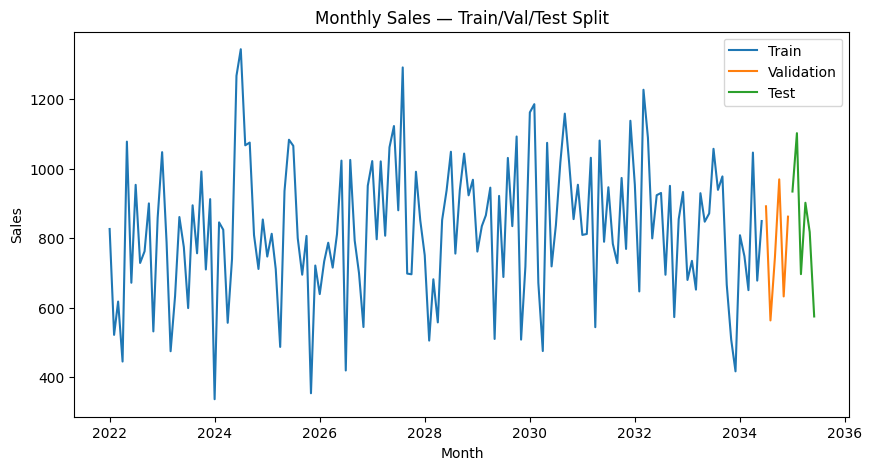

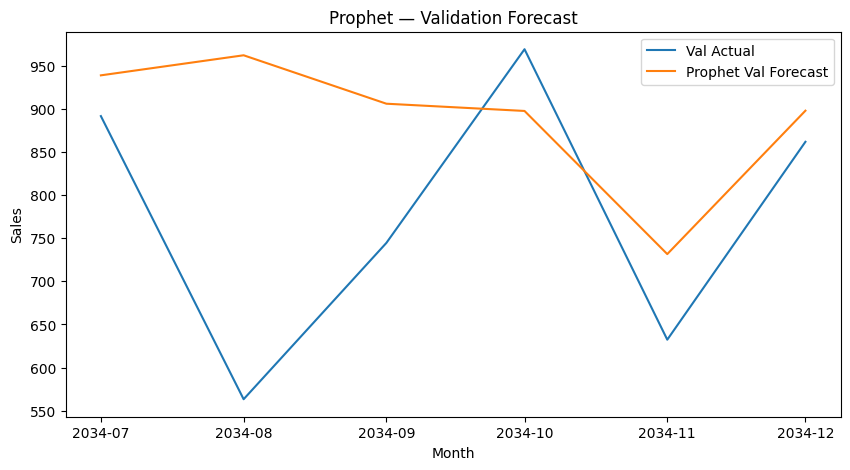

<Figure size 640x480 with 0 Axes>

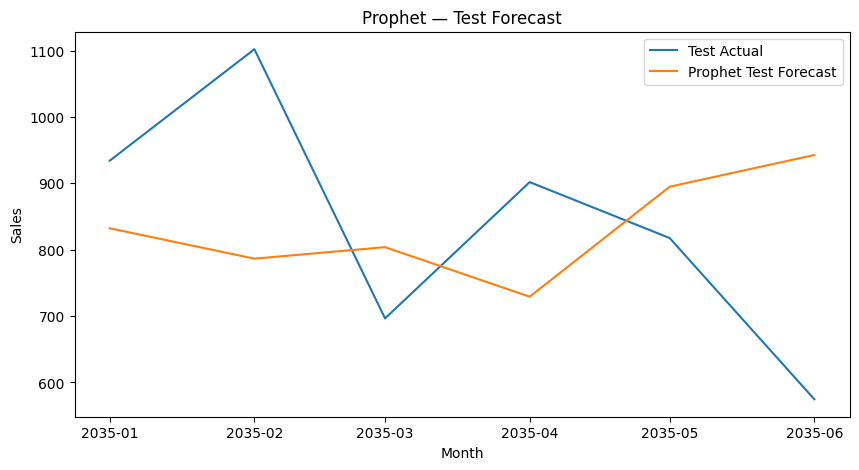

<Figure size 640x480 with 0 Axes>

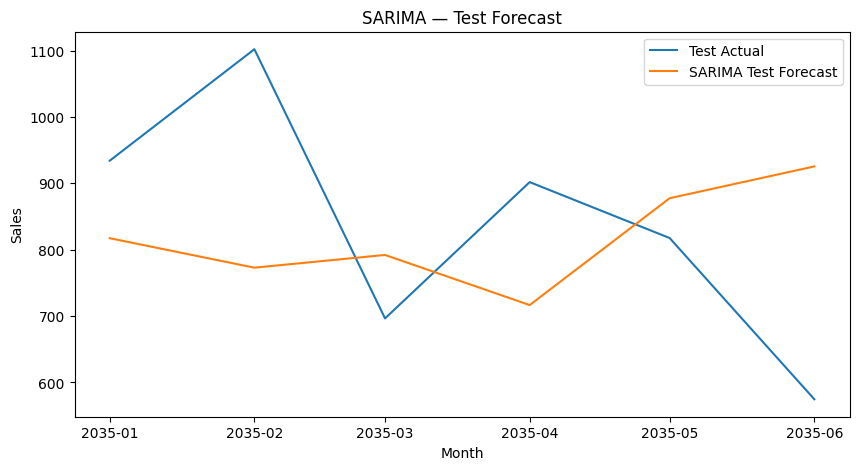

<Figure size 640x480 with 0 Axes>

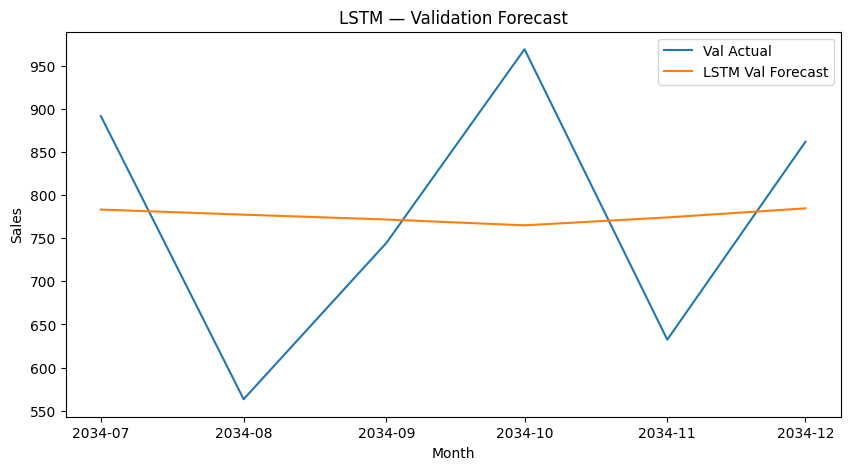

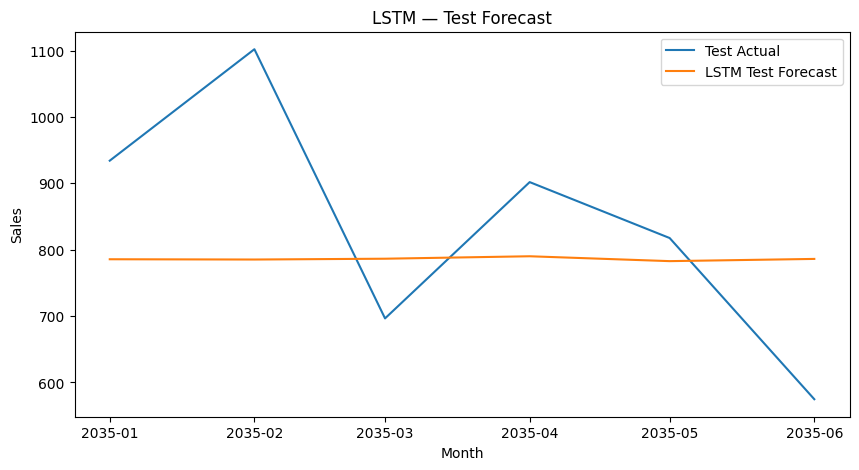

<Figure size 640x480 with 0 Axes>

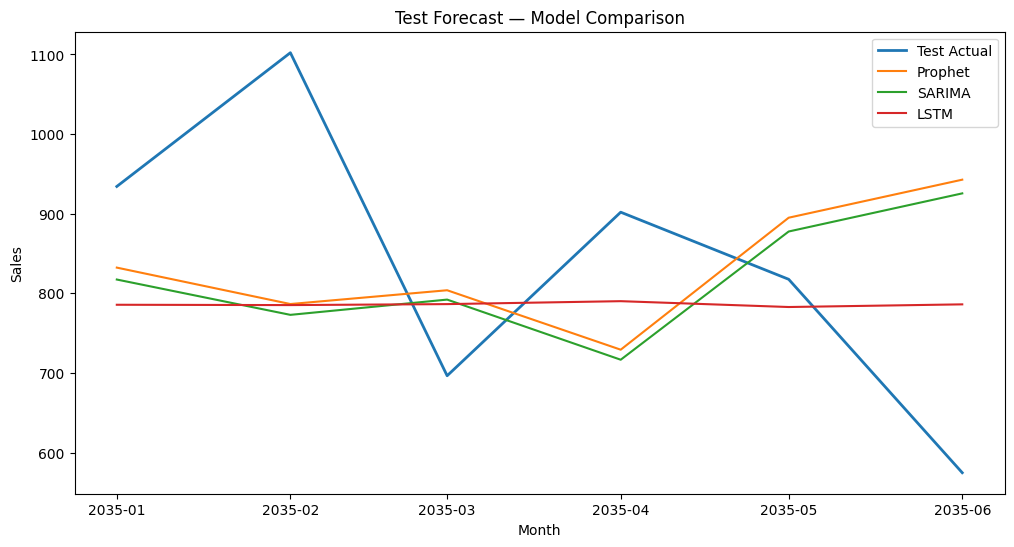

<Figure size 640x480 with 0 Axes>

In [13]:

plt.figure(figsize=(10,5))
plt.plot(train.index, train.values, label='Train')
plt.plot(val.index, val.values, label='Validation')
plt.plot(test.index, test.values, label='Test')
plt.title('Monthly Sales — Train/Val/Test Split')
plt.xlabel('Month'); plt.ylabel('Sales'); plt.legend(); plt.show()

# Prophet plots
plt.figure(figsize=(10,5))
plt.plot(val.index, val.values, label='Val Actual')
plt.plot(val.index, prophet_val_pred.values, label='Prophet Val Forecast')
plt.title('Prophet — Validation Forecast'); plt.xlabel('Month'); plt.ylabel('Sales'); plt.legend(); plt.show()
plt.savefig("images/prophet_test_forecast.png")

plt.figure(figsize=(10,5))
plt.plot(test.index, test.values, label='Test Actual')
plt.plot(test.index, prophet_test_pred.values, label='Prophet Test Forecast')
plt.title('Prophet — Test Forecast'); plt.xlabel('Month'); plt.ylabel('Sales'); plt.legend(); plt.show()
plt.savefig("images/prophet_test_forecast.png")

# SARIMA plots
plt.figure(figsize=(10,5))
plt.plot(test.index, test.values, label='Test Actual')
plt.plot(test.index, sarima_test_fc.values, label='SARIMA Test Forecast')
plt.title('SARIMA — Test Forecast'); plt.xlabel('Month'); plt.ylabel('Sales'); plt.legend(); plt.show()
plt.savefig("images/sarima_test_forecast.png")

# LSTM plots
plt.figure(figsize=(10,5))
plt.plot(val.index, lstm_result['val_true'], label='Val Actual')
plt.plot(val.index, lstm_result['val_pred'], label='LSTM Val Forecast')
plt.title('LSTM — Validation Forecast'); plt.xlabel('Month'); plt.ylabel('Sales'); plt.legend(); plt.show()


plt.figure(figsize=(10,5))
plt.plot(test.index, test.values, label='Test Actual')
plt.plot(test.index, lstm_result['test_pred'], label='LSTM Test Forecast')
plt.title('LSTM — Test Forecast'); plt.xlabel('Month'); plt.ylabel('Sales'); plt.legend(); plt.show()
plt.savefig("images/lstm_test_forecast.png")

# Combined Test comparison
plt.figure(figsize=(12,6))
plt.plot(test.index, test.values, label='Test Actual', linewidth=2)
plt.plot(test.index, prophet_test_pred.values, label='Prophet')
plt.plot(test.index, sarima_test_fc.values, label='SARIMA')
plt.plot(test.index, lstm_result['test_pred'], label='LSTM')
plt.title('Test Forecast — Model Comparison'); plt.xlabel('Month'); plt.ylabel('Sales'); plt.legend(); plt.show()
plt.savefig("images/model_comparison.png")



## 11. Model Leaderboard (Metrics)


In [11]:

results = pd.DataFrame({
    'Model': ['Prophet', 'SARIMA', 'LSTM'],
    'RMSE_Test': [p_rmse_test, s_rmse_test, lstm_result['metrics_test'][0]],
    'MAE_Test':  [p_mae_test,  s_mae_test,  lstm_result['metrics_test'][1]],
    'MAPE_Test': [p_mape_test, s_mape_test, lstm_result['metrics_test'][2]]
}).sort_values('RMSE_Test')
results


,Model,RMSE_Test,MAE_Test,MAPE_Test
2,LSTM,177.525941,152.273726,18.506843
1,SARIMA,220.719440,189.676347,24.179208
0,Prophet,220.939314,190.528369,24.606971



## 12. Notes & Extensions

- **Holiday effects**: Add a holiday dataframe to Prophet for festivals (e.g., Diwali, Christmas).  
- **Per-store/per-item forecasts**: Switch `GROUP_MODE` and loop over IDs; save outputs by segment.  
- **Confidence intervals**: Enable & plot Prophet/SARIMA intervals for uncertainty.  
- **Model persistence**: Save models and forecasts as CSV/PKL for reports.  
- **Explainability**: Use SHAP for ML models (if you add XGBoost/LightGBM later).

**This notebook is designed to be submission-ready** for a Monthly Sales Forecasting project showcasing classical, probabilistic, and deep learning approaches with clear evaluation and visualizations.
